# Action1 surprise工具对MovieLens数据集进行评分预测

# Baseline算法：基于统计的基准预测线打分

##### **基准算法包含两个主要的算法NormalPredictor和BaselineOnly**

Normal Perdictor 认为用户对物品的评分是服从正态分布的，从而可以根据已有的评分的均值和方差 预测当前用户对其他物品评分的分数。

Baseline算法的思想就是设立基线，并引入用户的偏差以及item的偏差

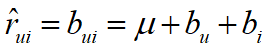

μ为所有用户对电影评分的均值
bui：待求的基线模型中用户u给物品i打分的预估值
bu：user偏差（如果用户比较苛刻，打分都相对偏低， 则bu<0；反之，bu>0）；
bi为item偏差，反映商品受欢迎程度

In [2]:
#from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly, KNNBasic, NormalPredictor
from surprise import accuracy
from surprise.model_selection import KFold
#import pandas as pd

# 数据读取
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('./ratings.csv', reader=reader)
train_set = data.build_full_trainset()

In [22]:
train_set?

Type:        Trainset
String form: <surprise.trainset.Trainset object at 0x0000027DEE3D39D0>
File:        d:\学习\研究生\算法工程师\bi\bi_env\lib\site-packages\surprise\trainset.py
Docstring:  
A trainset contains all useful data that constitute a training set.

It is used by the :meth:`fit()
<surprise.prediction_algorithms.algo_base.AlgoBase.fit>` method of every
prediction algorithm. You should not try to build such an object on your
own but rather use the :meth:`Dataset.folds()
<surprise.dataset.Dataset.folds>` method or the
:meth:`DatasetAutoFolds.build_full_trainset()
<surprise.dataset.DatasetAutoFolds.build_full_trainset>` method.

Trainsets are different from :class:`Datasets <surprise.dataset.Dataset>`.
You can think of a :class:`Dataset <surprise.dataset.Dataset>` as the raw
data, and Trainsets as higher-level data where useful methods are defined.
Also, a :class:`Dataset <surprise.dataset.Dataset>` may be comprised of
multiple Trainsets (e.g. when doing cross validation).


Attributes:

In [36]:
# 定义K折交叉验证迭代器，K=3
kf = KFold(n_splits=3)

uid = str(196)
iid = str(302)
# 输出uid对iid的预测结果
# pred = algo.predict(uid, iid, r_ui=4, verbose=True)

**使用ALS进行优化**

Step1，固定bu，优化bi

Step2，固定bi，优化bu

ALS 求得Bi和Bu，也就是评分矩阵


In [42]:
%%time
#默认采用ALS默认参数的BaselineOnly结果
algo = BaselineOnly()
for trainset, testset in kf.split(data):
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

Estimating biases using als...
RMSE: 0.8676
Estimating biases using als...
RMSE: 0.8656
Estimating biases using als...
RMSE: 0.8648
user: 196        item: 302        r_ui = 4.00   est = 4.04   {'was_impossible': False}
Wall time: 26.1 s


In [43]:
%%time
#无优化使用NormalPredictor结果
algo = NormalPredictor()
for trainset, testset in kf.split(data):
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

RMSE: 1.4322
RMSE: 1.4320
RMSE: 1.4311
user: 196        item: 302        r_ui = 4.00   est = 4.22   {'was_impossible': False}
Wall time: 19.1 s


In [44]:
%%time
# ALS优化结果
#ALS参数:reg_i：物品的正则化参数，默认为10。reg_u：用户的正则化参数，默认为15 。n_epochs：迭代次数，默认为10

bsl_options = {'method': 'als','n_epochs': 5,'reg_u': 12,'reg_i': 5}
algo = BaselineOnly(bsl_options=bsl_options)
for trainset, testset in kf.split(data):
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

Estimating biases using als...
RMSE: 0.8648
Estimating biases using als...
RMSE: 0.8640
Estimating biases using als...
RMSE: 0.8630
user: 196        item: 302        r_ui = 4.00   est = 4.02   {'was_impossible': False}
Wall time: 21 s


In [45]:
%%time
# SGD优化结果
#SGD参数:reg：代价函数的正则化项，默认为0.02。learning_rate：学习率，默认为0.005。n_epochs：迭代次数，默认为20。
bsl_options = {'method': 'sgd','n_epochs': 5}
algo = BaselineOnly(bsl_options=bsl_options)
for trainset, testset in kf.split(data):
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

Estimating biases using sgd...
RMSE: 0.8750
Estimating biases using sgd...
RMSE: 0.8742
Estimating biases using sgd...
RMSE: 0.8738
user: 196        item: 302        r_ui = 4.00   est = 4.08   {'was_impossible': False}
Wall time: 19.3 s


<font color=red size=8>可以看出，没有经过ALS和SGD优化的算法，运行时间较长，且RMSE偏高。</font>

## SlopeOne算法

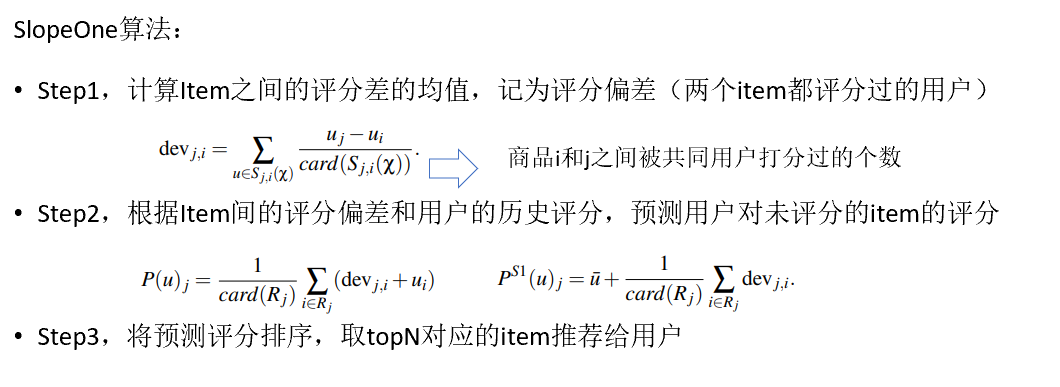

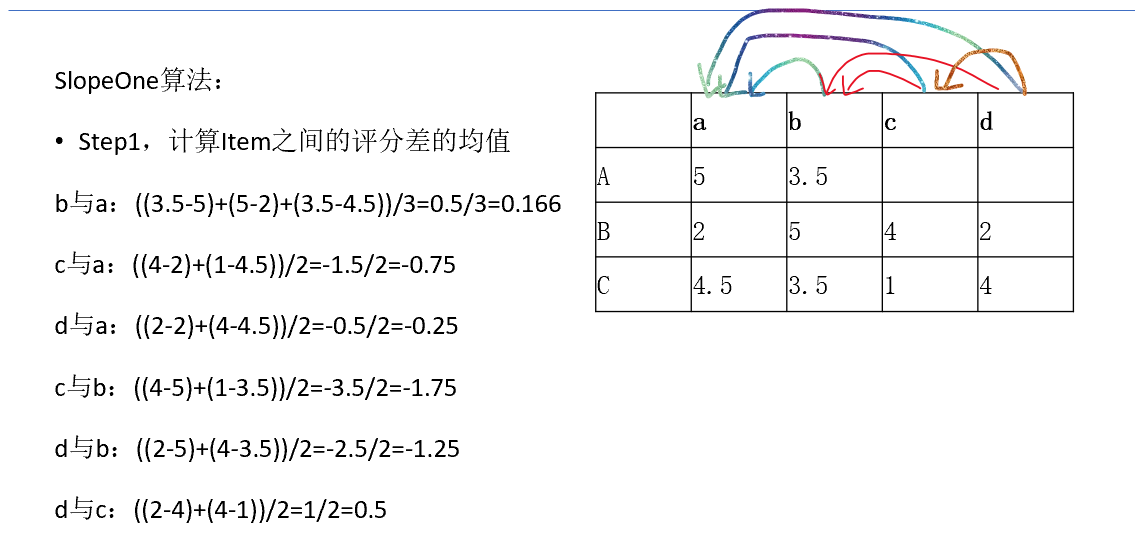
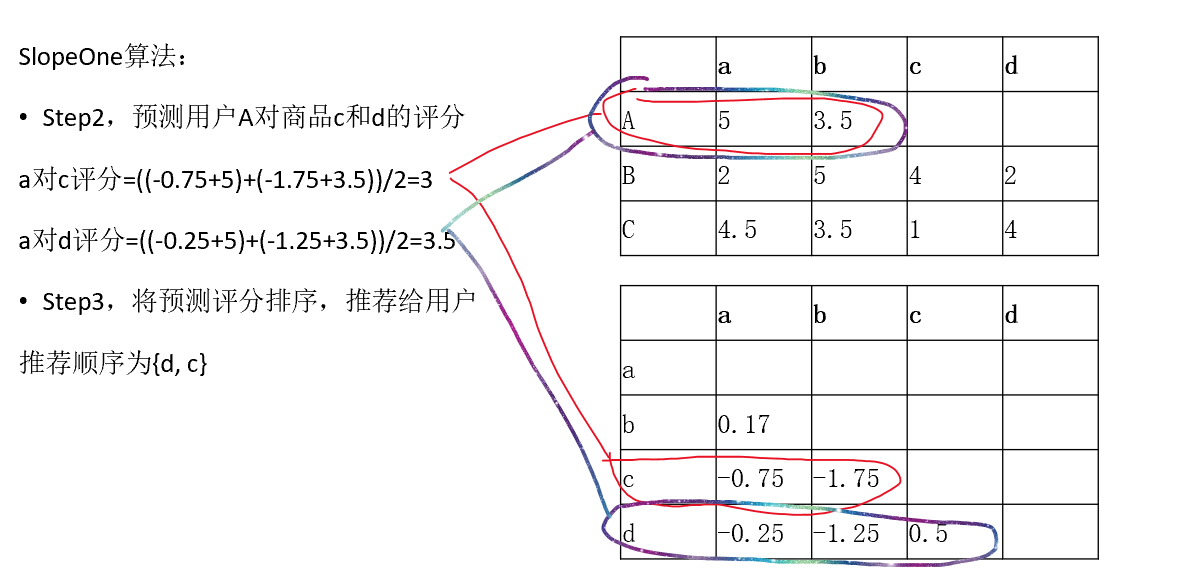

In [47]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
#from surprise import evaluate, print_perf
from surprise import Reader
from surprise import BaselineOnly, KNNBasic, KNNBaseline, SlopeOne
from surprise import accuracy
from surprise.model_selection import KFold
import pandas as pd
import io
import pandas as pd

# 读取物品（电影）名称信息
def read_item_names():
    file_name = ('./movies.csv') 
    data = pd.read_csv('./movies.csv')
    rid_to_name = {}
    name_to_rid = {}
    for i in range(len(data['movieId'])):
        rid_to_name[data['movieId'][i]] = data['title'][i]
        name_to_rid[data['title'][i]] = data['movieId'][i]

    return rid_to_name, name_to_rid 

# 数据读取
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('./ratings.csv', reader=reader)
train_set = data.build_full_trainset()

In [50]:
%%time
# 使用SlopeOne算法
algo = SlopeOne()
algo.fit(train_set)
# 对指定用户和商品进行评分预测
uid = str(196) 
iid = str(302) 
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 196        item: 302        r_ui = 4.00   est = 4.32   {'was_impossible': False}
Wall time: 1min


<font color=red size=5>SlopeOne算法相比Baseline算法耗时更长</font>

# from pyspark.ml.recommendation import ALS 方法对电影top-N推荐

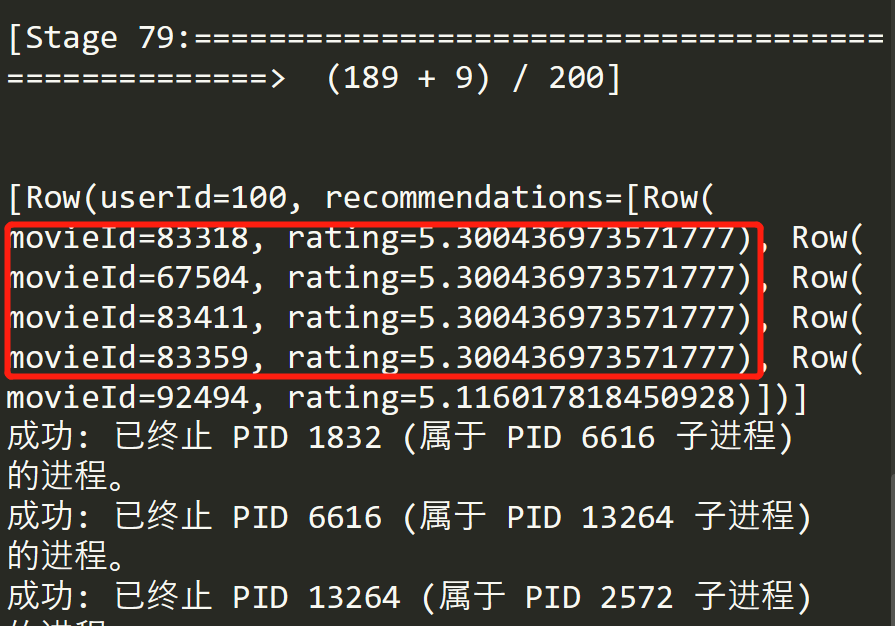